## VGG-16 cummulative correlation analysis.

LPIPS is a common perceptual metric. It uses a concatenation of five VGG-16 layer outputs (Block1_conv2, Block2_conv2, Block3_conv3, Block4_conv3 and Block5_conv3) to calculate the inner distance and correlate it with the mean opinion score (mos). We want to explore how the correlation between the inner distance and the mos changes when we concatenate layer outputs. 

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Load the ImageNet pretrained VGG-16. From: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
vgg = tf.keras.applications.VGG16(input_shape=(384,512,3),
                                  include_top=False,
                                  weights='imagenet')

print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 128, 128)      0     

Load two image quality databases: TID-2013 and KADIK-10K. Each one has the following structure: image, distorted_image, mos. Preprocess the images with the VGG-16 preprocess.

In [5]:
tid_path_2013 = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013'
data_tid_2013 = pd.read_csv(tid_path_2013 + '/image_pairs_mos.csv', index_col = 0)


def train_gen_tid2013():
    for i, row in data_tid_2013.iterrows():
        img = cv2.imread(tid_path_2013 + '/reference_images/' + row.Reference)
        dist_img = cv2.imread(tid_path_2013 + '/distorted_images/' + row.Distorted)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        dist_img = tf.keras.applications.vgg16.preprocess_input(dist_img)
        #img = img/255.0
        #dist_img = dist_img/255.0
        yield img, dist_img, row.MOS

tid2013_dataset = tf.data.Dataset.from_generator(train_gen_tid2013,
                                                 output_signature=(
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (), dtype=tf.float32)))

print(tid2013_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [6]:
kadik_path = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K'
data_kadik = pd.read_csv(kadik_path + '/dmos.csv')

def train_gen_kadik():
    for i, row in data_kadik.iterrows():
        img = cv2.imread(kadik_path + '/images/' + row.ref_img)
        dist_img = cv2.imread(kadik_path + '/images/' + row.dist_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        dist_img = tf.keras.applications.vgg16.preprocess_input(dist_img)
        #img = img/255.0
        #dist_img = dist_img/255.0
        yield img, dist_img, row.dmos

kadik_dataset = tf.data.Dataset.from_generator(train_gen_kadik,
                                               output_signature=(
                                               tf.TensorSpec(shape = (384, 512, 3), dtype  =tf.float32),
                                               tf.TensorSpec(shape = (384, 512, 3), dtype = tf.float32),
                                               tf.TensorSpec(shape = (), dtype = tf.float32)))
print(kadik_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


Define models that arrive until the different five layers LPIPS concatenate. We will explore how the correlation changes as we use from one until the same five layer outputs.

In [7]:
model_1 = tf.keras.Sequential(vgg.layers[:3])
model_1.build(input_shape=(384,512,3))
model_1.summary()

model_2 = tf.keras.Sequential(vgg.layers[:6])
model_2.build(input_shape=(384,512,3))
model_2.summary()

model_3 = tf.keras.Sequential(vgg.layers[:10])
model_3.build(input_shape=(384,512,3))
model_3.summary()

model_4 = tf.keras.Sequential(vgg.layers[:14])
model_4.build(input_shape=(384,512,3))
model_4.summary()

model_5 = tf.keras.Sequential(vgg.layers[:18])
model_5.build(input_shape=(384,512,3))
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (

First we only use the output of the first layer that LPIPS uses. We pass throuth this model the image and distorted image from TID-2013 and KADIK-10K to calculate the distance with the outputs and then correlate these distances with the mos.

In [ ]:
moses_tid, distances_tid = [], []
moses_kadik, distances_kadik = [], []
tid_batch_size, kadik_batch_size = 5, 5

for imgs, dists, mos in tid2013_dataset.batch(tid_batch_size):
    moses_tid.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    # The ouputs of the different layers have different shapes so we flatten them to concatenate.
    preds_img = np.concatenate([preds_img_1.reshape(tid_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(tid_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_tid.extend(l2)
print(f'TID-2013 correlations:\n pearson = {stats.pearsonr(moses_tid, distances_tid)[0]} \n spearman{stats.spearmanr(moses_tid, distances_tid)[0]}')

for imgs, dists, mos in kadik_dataset.batch(kadik_batch_size):
    moses_kadik.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img = np.concatenate([preds_img_1.reshape(kadik_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(kadik_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_kadik.extend(l2)
print(f'KADIK-10K correlations:\n pearson = {stats.pearsonr(moses_kadik, distances_kadik)[0]} \n spearman{stats.spearmanr(moses_kadik, distances_kadik)[0]}')


Now we concatenate the outputs of the tow first layers that LPIPS uses.

In [ ]:
moses_tid, distances_tid = [], []
moses_kadik, distances_kadik = [], []
tid_batch_size, kadik_batch_size = 5, 5

for imgs, dists, mos in tid2013_dataset.batch(tid_batch_size):
    moses_tid.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    # The ouputs of the different layers have different shapes so we flatten them to concatenate.
    preds_img = np.concatenate([preds_img_1.reshape(tid_batch_size,-1), preds_img_2.reshape(tid_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(tid_batch_size,-1), preds_dist_2.reshape(tid_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_tid.extend(l2)
print(f'TID-2013 correlations:\n pearson = {stats.pearsonr(moses_tid, distances_tid)[0]} \n spearman{stats.spearmanr(moses_tid, distances_tid)[0]}')

for imgs, dists, mos in kadik_dataset.batch(kadik_batch_size):
    moses_kadik.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img = np.concatenate([preds_img_1.reshape(kadik_batch_size,-1), preds_img_2.reshape(kadik_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(kadik_batch_size,-1), preds_dist_2.reshape(kadik_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_kadik.extend(l2)
print(f'KADIK-10K correlations:\n pearson = {stats.pearsonr(moses_kadik, distances_kadik)[0]} \n spearman{stats.spearmanr(moses_kadik, distances_kadik)[0]}')


And continue adding layer outputs until the five layers that LPIPS uses. Three layer outputs.

In [ ]:
moses_tid, distances_tid = [], []
moses_kadik, distances_kadik = [], []
tid_batch_size, kadik_batch_size = 5, 5

for imgs, dists, mos in tid2013_dataset.batch(tid_batch_size):
    moses_tid.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    # The ouputs of the different layers have different shapes so we flatten them to concatenate.
    preds_img = np.concatenate([preds_img_1.reshape(tid_batch_size,-1), preds_img_2.reshape(tid_batch_size,-1),
                                preds_img_3.reshape(tid_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(tid_batch_size,-1), preds_dist_2.reshape(tid_batch_size,-1), 
                                 preds_dist_3.reshape(tid_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_tid.extend(l2)
print(f'TID-2013 correlations:\n pearson = {stats.pearsonr(moses_tid, distances_tid)[0]} \n spearman{stats.spearmanr(moses_tid, distances_tid)[0]}')

for imgs, dists, mos in kadik_dataset.batch(kadik_batch_size):
    moses_kadik.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img = np.concatenate([preds_img_1.reshape(kadik_batch_size,-1), preds_img_2.reshape(kadik_batch_size,-1),
                                preds_img_3.reshape(kadik_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(kadik_batch_size,-1), preds_dist_2.reshape(kadik_batch_size,-1), 
                                 preds_dist_3.reshape(kadik_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_kadik.extend(l2)
print(f'KADIK-10K correlations:\n pearson = {stats.pearsonr(moses_kadik, distances_kadik)[0]} \n spearman{stats.spearmanr(moses_kadik, distances_kadik)[0]}')

Four layer outputs.

In [ ]:
moses_tid, distances_tid = [], []
moses_kadik, distances_kadik = [], []
tid_batch_size, kadik_batch_size = 5, 5

for imgs, dists, mos in tid2013_dataset.batch(tid_batch_size):
    moses_tid.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img_4 = model_4(imgs).numpy()
    preds_dist_4 = model_4(dists).numpy()

    # The ouputs of the different layers have different shapes so we flatten them to concatenate.
    preds_img = np.concatenate([preds_img_1.reshape(tid_batch_size,-1), preds_img_2.reshape(tid_batch_size,-1),
                                preds_img_3.reshape(tid_batch_size,-1), preds_img_4.reshape(tid_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(tid_batch_size,-1), preds_dist_2.reshape(tid_batch_size,-1), 
                                 preds_dist_3.reshape(tid_batch_size,-1), preds_dist_4.reshape(tid_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_tid.extend(l2)
print(f'TID-2013 correlations:\n pearson = {stats.pearsonr(moses_tid, distances_tid)[0]} \n spearman{stats.spearmanr(moses_tid, distances_tid)[0]}')

for imgs, dists, mos in kadik_dataset.batch(kadik_batch_size):
    moses_kadik.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img_4 = model_4(imgs).numpy()
    preds_dist_4 = model_4(dists).numpy()

    preds_img = np.concatenate([preds_img_1.reshape(kadik_batch_size,-1), preds_img_2.reshape(kadik_batch_size,-1),
                                preds_img_3.reshape(kadik_batch_size,-1), preds_img_4.reshape(kadik_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(kadik_batch_size,-1), preds_dist_2.reshape(kadik_batch_size,-1), 
                                 preds_dist_3.reshape(kadik_batch_size,-1), preds_dist_4.reshape(kadik_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_kadik.extend(l2)
print(f'KADIK-10K correlations:\n pearson = {stats.pearsonr(moses_kadik, distances_kadik)[0]} \n spearman{stats.spearmanr(moses_kadik, distances_kadik)[0]}')


All the layer outputs that LPIPS uses.

In [5]:
moses_tid, distances_tid = [], []
moses_kadik, distances_kadik = [], []
tid_batch_size, kadik_batch_size = 5, 5

for imgs, dists, mos in tid2013_dataset.batch(tid_batch_size):
    moses_tid.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img_4 = model_4(imgs).numpy()
    preds_dist_4 = model_4(dists).numpy()

    preds_img_5 = model_5(imgs).numpy()
    preds_dist_5 = model_5(dists).numpy()

    # The ouputs of the different layers have different shapes so we flatten them to concatenate.
    preds_img = np.concatenate([preds_img_1.reshape(tid_batch_size,-1), preds_img_2.reshape(tid_batch_size,-1),
                                preds_img_3.reshape(tid_batch_size,-1), preds_img_4.reshape(tid_batch_size,-1),
                                preds_img_5.reshape(tid_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(tid_batch_size,-1), preds_dist_2.reshape(tid_batch_size,-1), 
                                 preds_dist_3.reshape(tid_batch_size,-1), preds_dist_4.reshape(tid_batch_size,-1),
                                 preds_dist_5.reshape(tid_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_tid.extend(l2)
print(f'TID-2013 correlations:\n pearson = {stats.pearsonr(moses_tid, distances_tid)[0]} \n spearman{stats.spearmanr(moses_tid, distances_tid)[0]}')

for imgs, dists, mos in kadik_dataset.batch(kadik_batch_size):
    moses_kadik.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img_4 = model_4(imgs).numpy()
    preds_dist_4 = model_4(dists).numpy()

    preds_img_5 = model_5(imgs).numpy()
    preds_dist_5 = model_5(dists).numpy()
    
    preds_img = np.concatenate([preds_img_1.reshape(kadik_batch_size,-1), preds_img_2.reshape(kadik_batch_size,-1),
                                preds_img_3.reshape(kadik_batch_size,-1), preds_img_4.reshape(kadik_batch_size,-1),
                                preds_img_5.reshape(kadik_batch_size,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(kadik_batch_size,-1), preds_dist_2.reshape(kadik_batch_size,-1), 
                                 preds_dist_3.reshape(kadik_batch_size,-1), preds_dist_4.reshape(kadik_batch_size,-1),
                                 preds_dist_5.reshape(kadik_batch_size,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances_kadik.extend(l2)
print(f'KADIK-10K correlations:\n pearson = {stats.pearsonr(moses_kadik, distances_kadik)[0]} \n spearman{stats.spearmanr(moses_kadik, distances_kadik)[0]}')


In order to not run the experiments each time, these are the results.

In [8]:
tid_pearson = [0.598, 0.788, 0.819, 0.827, 0.827, 0.827]
tid_spearman = [0.687, 0.803, 0.828, 0.832, 0.833, 0.833] 
kadik_pearson = [0.550, 0.611, 0.752, 0.781, 0.781, 0.781]
kadik_spearman = [0.676, 0.786, 0.838, 0.847, 0.847, 0.847]

layer_names = ['Input', 'Block1_conv2', 'Block1_conv2 +\nBlock2_conv2', 'Block1_conv2 +\nBlock2_conv2 +\nBlock3_conv3', 'Block1_conv2 +\nBlock2_conv2 +\nBlock3_conv3 +\nBlock4_conv3', 
               'Block1_conv2 +\nBlock2_conv2 +\nBlock3_conv3 +\nBlock4_conv3 +\nBlock5_conv3']

Plot the results for TID-2013 spearman and pearson correlation as we concatenate up to five layer outputs. Colors indicate the different VGG-16 blocks.

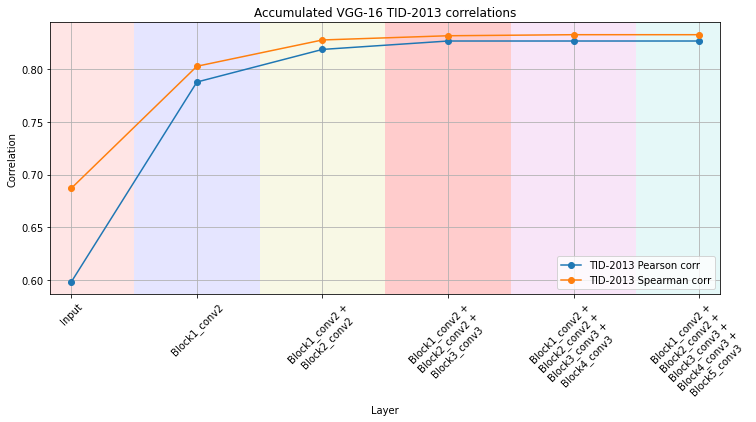

In [9]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(0,18,3), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
plt.plot(np.arange(0,18,3), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
plt.axvspan(-0.5, 1.5, color='r', alpha=0.1, lw=0)
plt.axvspan(1.5, 4.5, color='b', alpha=0.1, lw=0)
plt.axvspan(4.5, 7.5, color='y', alpha=0.1, lw=0)
plt.axvspan(7.5, 10.5, color='r', alpha=0.2, lw=0)
plt.axvspan(10.5, 13.5, color='m', alpha=0.1, lw=0)
plt.axvspan(13.5, 18.5, color='c', alpha=0.1, lw=0)
plt.xticks(np.arange(0,18,3), [layer for layer in layer_names], rotation = 45)
plt.title('Accumulated VGG-16 TID-2013 correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,15.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

Same plot for KADIK-10K results.

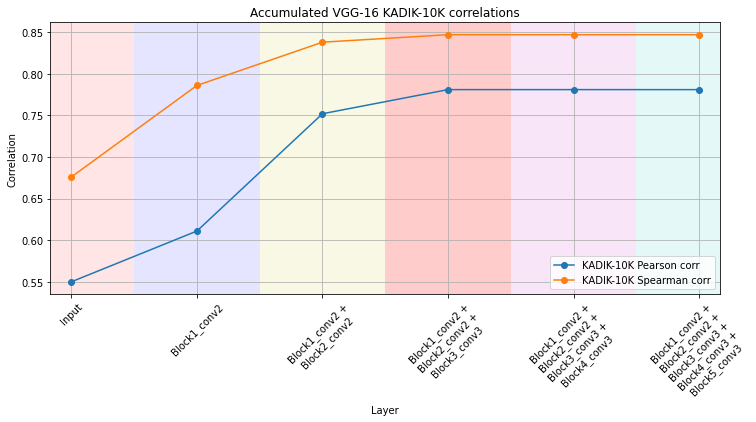

In [10]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(0,18,3), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
plt.plot(np.arange(0,18,3), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
plt.axvspan(-0.5, 1.5, color='r', alpha=0.1, lw=0)
plt.axvspan(1.5, 4.5, color='b', alpha=0.1, lw=0)
plt.axvspan(4.5, 7.5, color='y', alpha=0.1, lw=0)
plt.axvspan(7.5, 10.5, color='r', alpha=0.2, lw=0)
plt.axvspan(10.5, 13.5, color='m', alpha=0.1, lw=0)
plt.axvspan(13.5, 18.5, color='c', alpha=0.1, lw=0)
plt.xticks(np.arange(0,18,3), [layer for layer in layer_names], rotation = 45)
plt.title('Accumulated VGG-16 KADIK-10K correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,15.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

To compare both results we plot them together with the same scale.

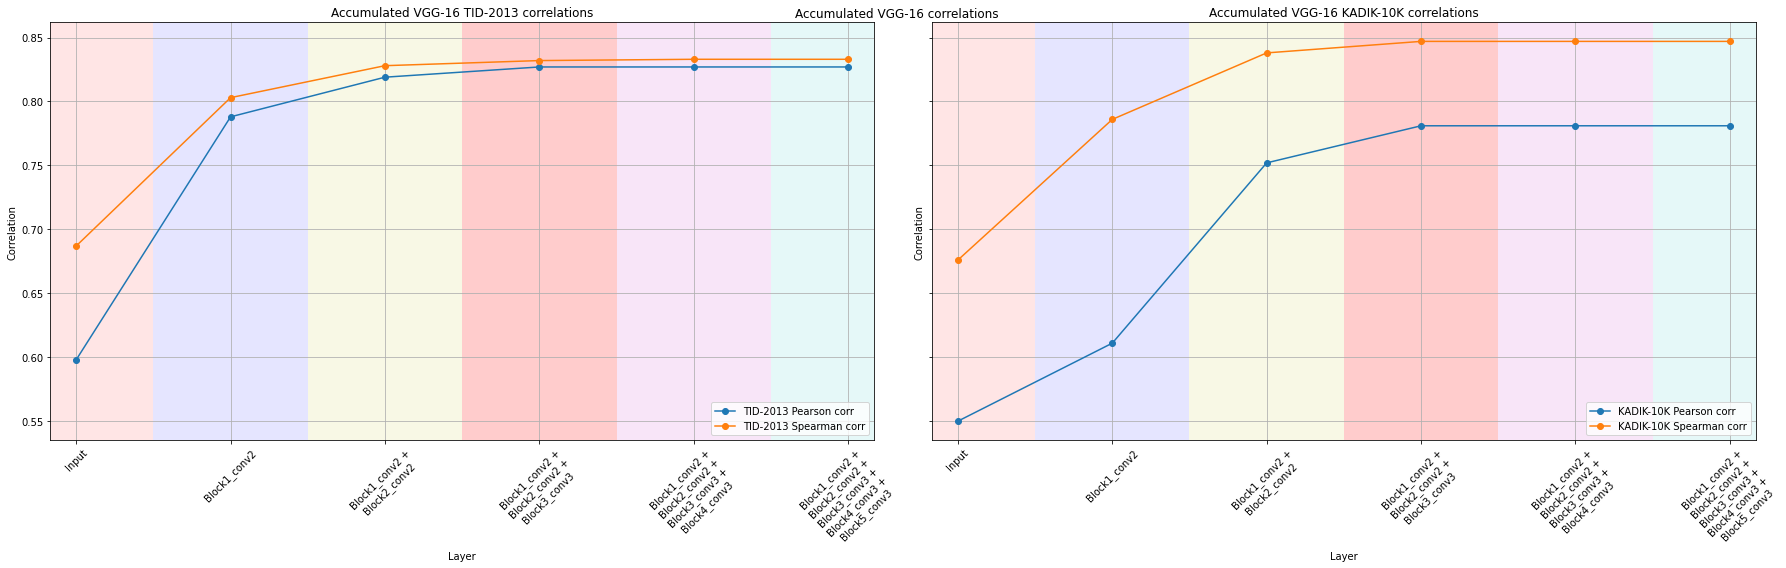

In [11]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (25,8))
ax[0].plot(np.arange(0,18,3), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
ax[0].plot(np.arange(0,18,3), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
ax[0].axvspan(-0.5, 1.5, color='r', alpha=0.1, lw=0)
ax[0].axvspan(1.5, 4.5, color='b', alpha=0.1, lw=0)
ax[0].axvspan(4.5, 7.5, color='y', alpha=0.1, lw=0)
ax[0].axvspan(7.5, 10.5, color='r', alpha=0.2, lw=0)
ax[0].axvspan(10.5, 13.5, color='m', alpha=0.1, lw=0)
ax[0].axvspan(13.5, 18.5, color='c', alpha=0.1, lw=0)
ax[0].set_xticks(np.arange(0,18,3), [layer for layer in layer_names], rotation = 45)
ax[0].set_title('Accumulated VGG-16 TID-2013 correlations')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Correlation')
ax[0].set_xlim([-0.5,15.5])
ax[0].legend(loc = 'lower right')
ax[0].grid()

ax[1].plot(np.arange(0,18,3), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
ax[1].plot(np.arange(0,18,3), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
ax[1].axvspan(-0.5, 1.5, color='r', alpha=0.1, lw=0)
ax[1].axvspan(1.5, 4.5, color='b', alpha=0.1, lw=0)
ax[1].axvspan(4.5, 7.5, color='y', alpha=0.1, lw=0)
ax[1].axvspan(7.5, 10.5, color='r', alpha=0.2, lw=0)
ax[1].axvspan(10.5, 13.5, color='m', alpha=0.1, lw=0)
ax[1].axvspan(13.5, 18.5, color='c', alpha=0.1, lw=0)
ax[1].set_xticks(np.arange(0,18,3), [layer for layer in layer_names], rotation = 45)
ax[1].set_title('Accumulated VGG-16 KADIK-10K correlations')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Correlation')
ax[1].set_xlim([-0.5,15.5])
ax[1].legend(loc = 'lower right')
ax[1].grid()
fig.tight_layout()
plt.suptitle('Accumulated VGG-16 correlations')
plt.show()
#plt.savefig('VGG_correlations.png', dpi = 1000)